In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import geopandas as gpd
import itertools, glob
from tqdm import tqdm

In [2]:
imputed = gpd.read_file(r'J:\Geology\WSGS\Projects\Critical Minerals\hotspot analysis\max_nure_with_hucs_polygon.shp')
hucs = gpd.read_file(r'J:\Geology\WSGS\GIS\huc_12.shp')
hucs = hucs.to_crs(crs={'init': 'epsg:3732'})

In [3]:
hucs = imputed

In [4]:
hucs['FID'] = hucs.index.values
#hucs.to_file(driver='ESRI Shapefile', filename='huc_12_fids.shp')

In [5]:
keys = hucs.loc[0:].FID #huc basin number

In [6]:
ds=[]
for i in range(len(hucs)):
    downstream = hucs[hucs['HUC_12'] == hucs.loc[i].HU_12_DS].FID.values
    ds.append(downstream)
#huc basin downstream of huc basin

In [7]:
us = []
for i in range(len(hucs)):
    upstream = hucs.loc[hucs['HU_12_DS'] == hucs.loc[i].HUC_12].FID.values
    us.append(upstream)

In [8]:
lso = []
for i in range(len(ds)):
    ls = []
    if ds[i].size>0:
        ls.append(ds[i][0])
    else:
        ls.append(-1)
    for j in range(len(us[i])):
        if us[i].size>0:
            ls.append(us[i][j])
        else:
            ls.append(-1)
    lso.append(ls)

In [9]:
neighbors = dict(zip(keys, lso))

In [10]:
def GangsterRoll(element):
    Xbar = hucs[element].mean() #calculates the mean value of the element across all HUCS
    S = np.sqrt((((hucs[element])**2).sum()/len(hucs))-(Xbar**2)) #calculates the S value in the denominator
    import scipy.sparse as sp #import bruh
    mat = sp.dok_matrix((len(hucs), len(hucs)), dtype=np.int8) #creates a sparse matrix based on a dictionary of keys from above
    for huc_a, huc_b in neighbors.items(): #this creates a sparse matrix of spatial contiguity weights
        mat[huc_a, huc_b] = 1
        mat = mat.transpose().tocsr()
    z_score = []
    for i in tqdm(range(len(hucs))): #here is the G* function that calculates the z-score
        try:
            row_standardized = mat.toarray()[i]/mat.toarray()[i].sum()
            numerator = ((hucs[element].values*row_standardized).sum())-(row_standardized.sum()*Xbar) #numerator
            denominator = np.sqrt(abs(((row_standardized**2).sum())-(row_standardized.sum())**2)/(len(row_standardized)-1))*S #denominator
            z_score.append(numerator/denominator)
        except:
            z_score.append(np.nan)
    hucs['z_score'] = z_score
    hucs['z_score'].replace([np.inf, -np.inf], np.nan, inplace=True)
    hucs['z_score'].fillna(0, inplace=True)
    G = hucs[[element, 'HUC_12', 'z_score', 'geometry']]
    G.to_file(driver='ESRI Shapefile', filename='./drainage hotspots/'+str(element)+'_hotspots.shp')
    H = hucs[[element, 'HUC_12', 'z_score']]
    H.to_csv(r'J:\\Geology\\WSGS\\Projects\\Critical Minerals\\hotspot analysis\\sed hotspot joined with hucs\\'+str(element)+'.csv')
    #G.plot(column='z_score', scheme='quantiles', legend=True)

In [149]:
element_list = hucs.columns[26:-6].values
for thing in element_list:
    GangsterRoll(thing)

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
  0%|                                                                                         | 0/2382 [00:00<?, ?it/s]C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
100%|█████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:20<00:00, 118.04it/s]


In [11]:
posi = dict(zip(keys, list(zip(hucs.centroid.x.values, hucs.centroid.y.values))))

In [12]:
import networkx as nx
G=nx.Graph()

In [13]:
G.add_nodes_from(hucs.FID.values)

In [14]:
edges = []
for i in range(len(keys)):
    val = list(filter(lambda a: a != -1, lso[i]))
    for j in range(len(val)):
        if np.sum(val)>0:
            edges.append((keys[i], val[j]))
        else:
            pass
    

In [15]:
G.add_edges_from(edges)

In [16]:
ti = pd.read_csv(r'J:/Geology/WSGS/Projects/Critical Minerals/hotspot analysis/sed hotspot joined with hucs/ti_ppm.csv')

In [17]:
path = r'J:\\Geology\\WSGS\\Projects\\Critical Minerals\\hotspot analysis\\sed hotspot joined with hucs\\REE\\'
allFiles=glob.glob(path+"*.csv")
frame=pd.DataFrame
listed=[]
for file in allFiles:
    df = pd.read_csv(file, index_col=[0])
    listed.append(df)
frame = pd.concat(listed, sort=False)

In [18]:
frame = frame.groupby('HUC_12', as_index=False).sum()

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\collections.py:902: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


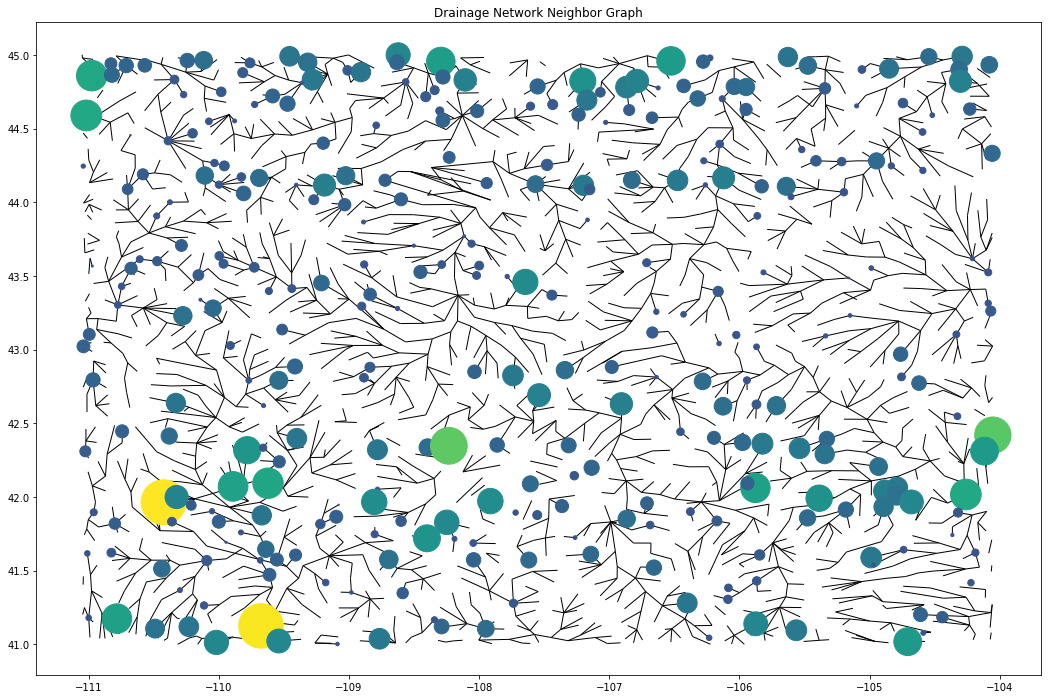

In [34]:
plt.figure(figsize=(18,12)) 
pos = nx.spring_layout(G,pos=posi)
nx.draw_networkx(G,pos=posi, with_labels=False, node_size=frame.z_score.values, node_color=frame.z_score.values, cmap='viridis')
plt.title('Drainage Network Neighbor Graph')
plt.savefig(r'J:\\Geology\\WSGS\\Projects\\Critical Minerals\\Report\\ree_network.png', dpi=600)


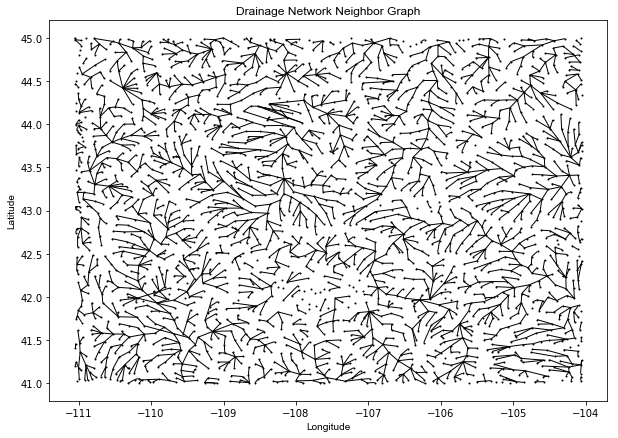

In [19]:
plt.figure(figsize=(10,7)) 
plt.title('Drainage Network Neighbor Graph', fontname="Arial")
plt.xlabel('Longitude', fontname="Arial")
plt.ylabel('Latitude', fontname="Arial")
nx.draw_networkx(G,pos=posi, with_labels=False, node_size=1, node_color='k')
plt.savefig('J:/Geology/WSGS/Projects/Critical Minerals/Report/v 0.2.0/figure 5a.png')

In [9]:
! pip install pysal

  Using cached https://files.pythonhosted.org/packages/56/8a/84537c0354f0d1f03bf644b71bf8e0a50db9c1294181905721a5f3efbf66/palettable-3.1.1-py2.py3-none-any.whl
  Stored in directory: C:\Users\jesse.pisel\AppData\Local\pip\Cache\wheels\ca\b9\69\49a64348ddb1feaf76b426c81c1db7275cfabacd8bf4ccd778
Successfully built pysal


You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [10]:
import pysal as ps

In [14]:
shp_path = 'J:\Geology\WSGS\Projects\Critical Minerals\hotspot analysis\max_nure_with_hucs_polygon.shp'
wq = ps.weights.Queen.from_shapefile(shp_path)
dataframe = ps.pdio.read_files(shp_path)

centroids = np.array([list(poly.centroid) for poly in dataframe.geometry])


AttributeError: module 'pysal' has no attribute 'weights'

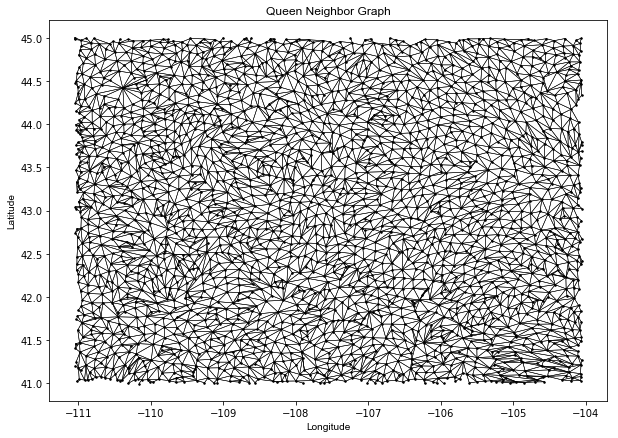

In [22]:
from pylab import figure, scatter, show
fig = figure(figsize=(10,7))

plt.plot(centroids[:,0], centroids[:,1],'.', color='k', markersize=3)
for k,neighs in wq.neighbors.items():
    #print(k,neighs)
    origin = centroids[k]
    for neigh in neighs:
        segment = centroids[[k,neigh]]
        plt.plot(segment[:,0], segment[:,1], color='k', linewidth=0.5)
plt.title('Queen Neighbor Graph', fontname="Arial")
plt.xlabel('Longitude',fontname="Arial")
plt.ylabel('Latitude', fontname="Arial")
plt.savefig('J:/Geology/WSGS/Projects/Critical Minerals/Report/v 0.2.0/figure 5b.png')